<h1>MODEL EVALUATOR</h1>

In [1]:
#LOAD DEPENDENCIES
import os
import cv2
import time
import pickle
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#Evaluation libraries
import itertools
import scikitplot 
import matplotlib.patheffects as path_effects
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, accuracy_score


#Model loader libraries
from pickle import load
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#LOAD THE DATA
train_data_dir = "kvasir-dataset-v2/train"
validation_data_dir = "kvasir-dataset-v2/val"
test_data_dir = "kvasir-dataset-v2/test"
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)
print("Data folders found!")
print("The Input size is set to ", model_input) 

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [3]:
fine_tune  = "MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz16_ep30"
fine_tune_time = "20241011-082553"

dir = f"models/{fine_tune}/"
history = f"{fine_tune}_{fine_tune_time}_history.pickle"
report = f"{fine_tune}_{fine_tune_time}_Classification_report.txt"
model_filename = f"{fine_tune}_{fine_tune_time}_model.h5"


In [4]:
#Load the model to evaluate

#Assign the constants
batch_size = 8
epochs = 20

#================================================================
model = load_model(f'{dir}{model_filename}')
print("**The model is successfully loaded**")
print("====================================")
print()
print("**Review as needed**")
print("------------------------------------")
model._name = 'MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz8_ep30_20241010-000734_model'
model.summary()
#================================================================


**The model is successfully loaded**

**Review as needed**
------------------------------------
Model: "MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz8_ep30_20241010-000734_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1_DCNN_A_DCNN_B_DCNN  [(None, 224, 224, 3)]        0         []                            
 _A_DCNN_B (InputLayer)                                                                           
                                                                                                  
 rescaling_2_DCNN_A (Rescal  (None, 224, 224, 3)          0         ['input_1_DCNN_A_DCNN_B_DCNN_A
 ing)                                                               _DCNN_B[0][0]']               
                                                                                                  
 normalization_1_DCNN_A (No  (None

In [5]:
#DATA GENERATORS
val_datagen = ImageDataGenerator(rescale = 1. / 255)

test_datagen = ImageDataGenerator(rescale = 1. / 255)


validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=['normal-cecum', 
                 'normal-pylorus', 
                 'normal-z-line', 
                 'polyps', 
                 'ulcerative-colitis', 
                 'esophagitis', 
                 'dyed-lifted-polyps', 
                 'dyed-resection-margins'])

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=['normal-cecum', 
                 'normal-pylorus', 
                 'normal-z-line', 
                 'polyps', 
                 'ulcerative-colitis', 
                 'esophagitis', 
                 'dyed-lifted-polyps', 
                 'dyed-resection-margins'])


#CHECK  THE NUMBER OF SAMPLES
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print("Validation samples:", nb_validation_samples)
print("Test samples:", nb_test_samples)

if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")
    
if nb_test_samples == 0:
    print("NO DATA TEST FOUND! Please check your test data path and folders!")
    print("Check the data folders first!")
else:
    print("Test samples found!")

#check the class indices
validation_generator.class_indices
test_generator.class_indices

#true labels
Y_test=validation_generator.classes
test_labels = test_generator.classes

num_classes= len(validation_generator.class_indices)

print('Model set to train', num_classes, 'classes')

if nb_validation_samples and nb_test_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 1280 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Validation samples: 1280
Test samples: 1600
Validation samples found!
Test samples found!
Model set to train 8 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


**VISUALIZATIONS**

In [6]:
#Modify only as needed

#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'

#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

#saver
image_format = '.tiff'
figure_path = "figures/"


In [7]:
#Load history
history = load(open(f'{dir}{history}', 'rb'))
print ("Loading history success")

Loading history success


In [8]:
# Validation Results

#evaluate accuracy
y_pred = model.predict(validation_generator,
                                 nb_validation_samples/batch_size, workers=1)

accuracy = accuracy_score(Y_test, y_pred.argmax(axis=-1))
print('The accuracy of the model is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test, y_pred.argmax(axis=-1))
print('The Mean Squared Error of the model is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test, y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the model is: ', msle)

160/160 [==============================] - 72s 438ms/step
The accuracy of the model is:  0.8109375
The Mean Squared Error of the model is:  1.27734375
The Mean Squared Log Error of the model is:  0.12188731553809236


In [9]:
# Validation Results
# Evaluate standard deviation 
std_dev = np.std(y_pred.argmax(axis=-1))

# Accuracy
accuracy_percentage = accuracy * 100  # Convert to percentage
std_dev_percentage = std_dev  # No need to divide by 100; std_dev is already a percentage
print(f'The accuracy of the predictions is: {accuracy_percentage:.2f}% ± {std_dev_percentage:.2f}%')
print(f'The accuracy of the predictions is: {accuracy:.4f} ± {std_dev:.4f}')


The accuracy of the predictions is: 81.09% ± 2.31%
The accuracy of the predictions is: 0.8109 ± 2.3099


In [10]:
# Test Results

#evaluate accuracy
test_pred = model.predict(test_generator,
                                 nb_test_samples/batch_size, workers=1)

test_accuracy = accuracy_score(test_labels, test_pred.argmax(axis=-1))
print('The accuracy of the model is: ', test_accuracy)

#evaluate mean squared error
test_mse = mean_squared_error(test_labels, test_pred.argmax(axis=-1))
print('The Mean Squared Error of the model is: ', test_mse)

#evaluate mean squared log error
test_msle = mean_squared_log_error(test_labels, test_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the model is: ', test_msle)

200/200 [==============================] - 84s 420ms/step
The accuracy of the model is:  0.804375
The Mean Squared Error of the model is:  1.45875
The Mean Squared Log Error of the model is:  0.1405288718759242


In [11]:
# Test Results
# Evaluate standard deviation
std_dev = np.std(test_pred.argmax(axis=-1))

# Accuracy
accuracy_percentage = test_accuracy * 100  # Convert to percentage
std_dev_percentage = std_dev  # No need to divide by 100; std_dev is already a percentage
print(f'The accuracy of the predictions is: {accuracy_percentage:.2f}% ± {std_dev_percentage:.2f}%')
print(f'The accuracy of the predictions is: {test_accuracy:.4f} ± {std_dev:.4f}')


The accuracy of the predictions is: 80.44% ± 2.31%
The accuracy of the predictions is: 0.8044 ± 2.3116


                        precision    recall  f1-score   support

          normal-cecum     0.8304    0.8875    0.8580       160
        normal-pylorus     0.7500    0.9938    0.8548       160
         normal-z-line     0.7679    0.8063    0.7866       160
                polyps     0.8129    0.7875    0.8000       160
    ulcerative-colitis     0.9630    0.8125    0.8814       160
           esophagitis     0.8148    0.6875    0.7458       160
    dyed-lifted-polyps     0.7545    0.7875    0.7706       160
dyed-resection-margins     0.8467    0.7250    0.7811       160

              accuracy                         0.8109      1280
             macro avg     0.8175    0.8109    0.8098      1280
          weighted avg     0.8175    0.8109    0.8098      1280

Normalized confusion matrix
[[0.8875 0.0563 0.     0.05   0.0063 0.     0.     0.    ]
 [0.     0.9938 0.0063 0.     0.     0.     0.     0.    ]
 [0.     0.075  0.8063 0.     0.     0.1187 0.     0.    ]
 [0.1    0.0938 0.     0

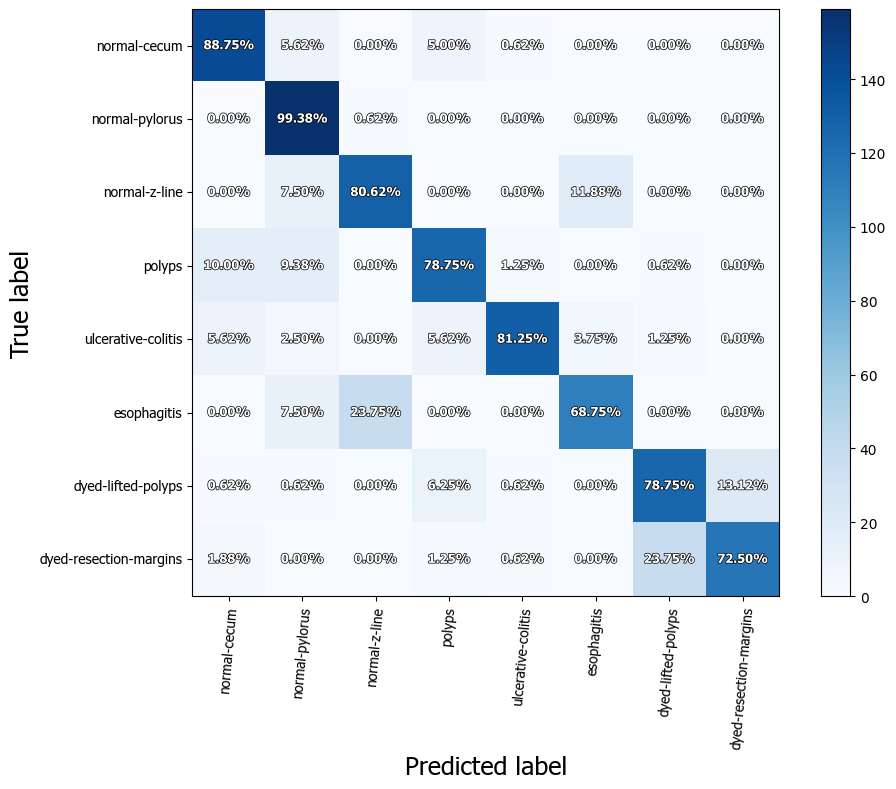

Classification report saved to models/MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz16_ep30/MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz16_ep30_20241011-082553_Classification_report.txt


In [12]:
# Confusion Matrix (Normalized)

fontsize= 10

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        std_dev = np.std(cm, axis=0)
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text_value = '{:.2f}%'.format(cm[i, j] * 100)
        if normalize:
          text_value += ' ± {:.2f}%'.format(std_dev[j] * 100)  # Append std_dev for normalized values
    
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

      # Print standard deviation (if applicable)
    if normalize:
      print("Standard Deviation:")
      print(std_dev * 100)  # Print std_dev as percentages
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps','ulcerative-colitis', 'esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins']

print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.show()
#================================================================


# Save classification report to file
report_filename = f"{dir}{report}"
with open(report_filename, "w") as report_file:
    report = classification_report(Y_test, y_pred.argmax(axis=-1), target_names=target_names, digits=4)
    report_file.write(report)
    print(f"Classification report saved to {report_filename}")

#================================================================


                        precision    recall  f1-score   support

          normal-cecum     0.8304    0.8875    0.8580       160
        normal-pylorus     0.7500    0.9938    0.8548       160
         normal-z-line     0.7679    0.8063    0.7866       160
                polyps     0.8129    0.7875    0.8000       160
    ulcerative-colitis     0.9630    0.8125    0.8814       160
           esophagitis     0.8148    0.6875    0.7458       160
    dyed-lifted-polyps     0.7545    0.7875    0.7706       160
dyed-resection-margins     0.8467    0.7250    0.7811       160

              accuracy                         0.8109      1280
             macro avg     0.8175    0.8109    0.8098      1280
          weighted avg     0.8175    0.8109    0.8098      1280

Confusion matrix, without normalization
[[142   9   0   8   1   0   0   0]
 [  0 159   1   0   0   0   0   0]
 [  0  12 129   0   0  19   0   0]
 [ 16  15   0 126   2   0   1   0]
 [  9   4   0   9 130   6   2   0]
 [  0  12  38 

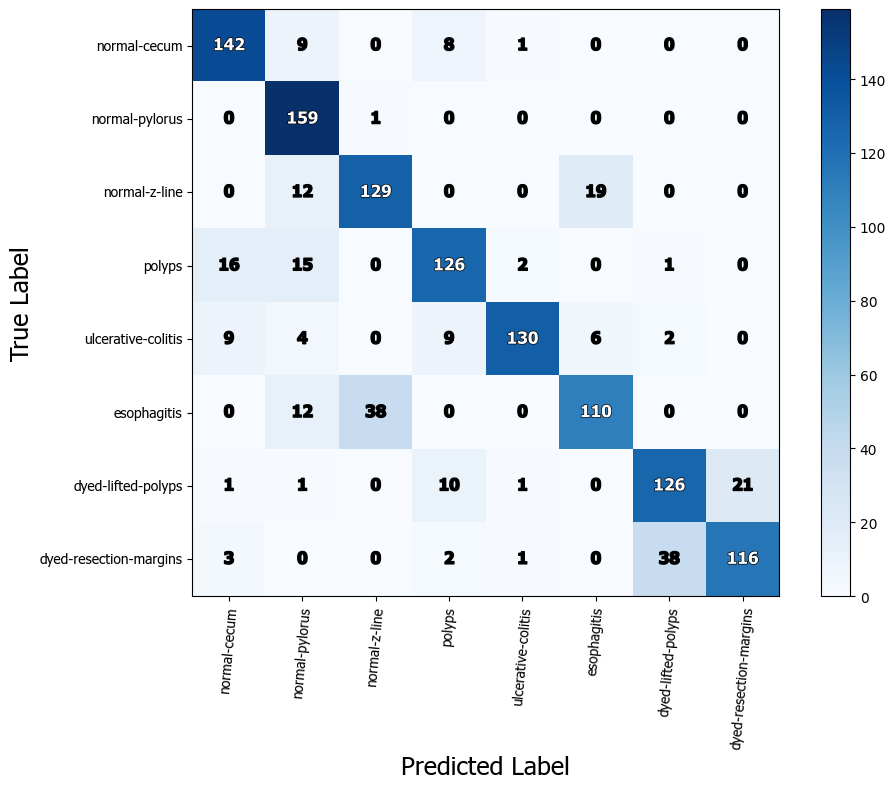

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.patheffects as path_effects
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix Visualization
fontsize = 10

def confusion_matrix_test(cm, classes,
                          normalize=False,  # if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Blues):  # Changed colormap to 'Blues'
    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85, fontfamily='Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily='Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, format(cm[i, j], 'd'),  # Changed format to integer display
                        fontfamily='Tahoma',
                        fontsize=12, weight='bold',
                        horizontalalignment="center", verticalalignment='center',
                        color="white" if cm[i, j] > thresh else "black")  # Adjust text color
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                               path_effects.Normal()])

    plt.tight_layout()
    plt.ylabel('True Label', fontfamily='Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted Label', fontfamily='Tahoma', fontsize=18)

# Print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps','ulcerative-colitis', 'esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins']

print(classification_report(Y_test, y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test, y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

# Save and show the confusion matrix
plt.savefig('confusion_matrix.png', 
            bbox_inches='tight', 
            dpi=600)
plt.show()


                        precision    recall  f1-score   support

          normal-cecum     0.8111    0.8800    0.8441       200
        normal-pylorus     0.7353    1.0000    0.8475       200
         normal-z-line     0.7451    0.7600    0.7525       200
                polyps     0.8301    0.8550    0.8424       200
    ulcerative-colitis     0.9623    0.7650    0.8524       200
           esophagitis     0.8137    0.6550    0.7258       200
    dyed-lifted-polyps     0.7477    0.8000    0.7729       200
dyed-resection-margins     0.8623    0.7200    0.7847       200

              accuracy                         0.8044      1600
             macro avg     0.8134    0.8044    0.8028      1600
          weighted avg     0.8134    0.8044    0.8028      1600

Normalized confusion matrix
[[0.88  0.06  0.    0.05  0.01  0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.11  0.76  0.    0.    0.13  0.    0.   ]
 [0.05  0.07  0.005 0.855 0.015 0.    0.005 0.  

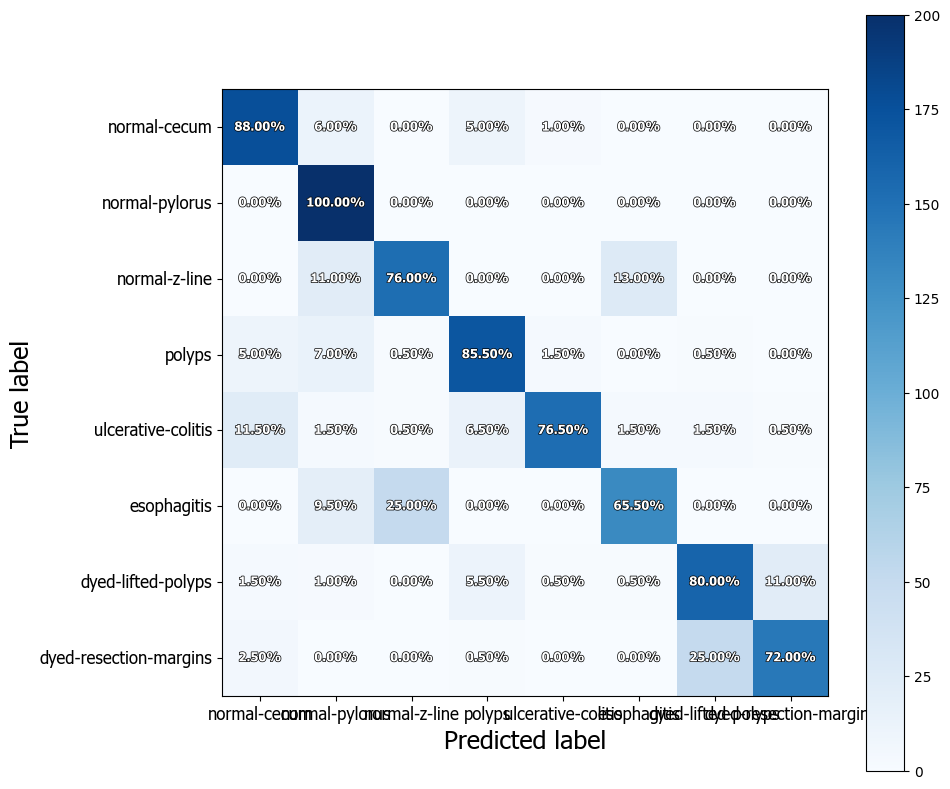

Classification report saved to models/MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz16_ep30/MFuReCNN_alpha_do_SGD_lr0.0001_aDo0.2_bz16_ep30_20241011-082553_Classification_report.txt


In [14]:
# Confusion Matrix (Normalized)

fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title='',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps','ulcerative-colitis', 'esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins']

print(classification_report(test_labels,test_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(test_labels,test_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()


plt.show()

#================================================================
# Save classification report to file for Test Set
with open(report_filename, "w") as report_file:
    report = classification_report(test_labels, test_pred.argmax(axis=-1), target_names=target_names, digits=4)
    report_file.write(report)
    print(f"Classification report saved to {report_filename}")

#================================================================


                        precision    recall  f1-score   support

          normal-cecum     0.8111    0.8800    0.8441       200
        normal-pylorus     0.7353    1.0000    0.8475       200
         normal-z-line     0.7451    0.7600    0.7525       200
                polyps     0.8301    0.8550    0.8424       200
    ulcerative-colitis     0.9623    0.7650    0.8524       200
           esophagitis     0.8137    0.6550    0.7258       200
    dyed-lifted-polyps     0.7477    0.8000    0.7729       200
dyed-resection-margins     0.8623    0.7200    0.7847       200

              accuracy                         0.8044      1600
             macro avg     0.8134    0.8044    0.8028      1600
          weighted avg     0.8134    0.8044    0.8028      1600

Confusion matrix, without normalization
[[176  12   0  10   2   0   0   0]
 [  0 200   0   0   0   0   0   0]
 [  0  22 152   0   0  26   0   0]
 [ 10  14   1 171   3   0   1   0]
 [ 23   3   1  13 153   3   3   1]
 [  0  19  50 

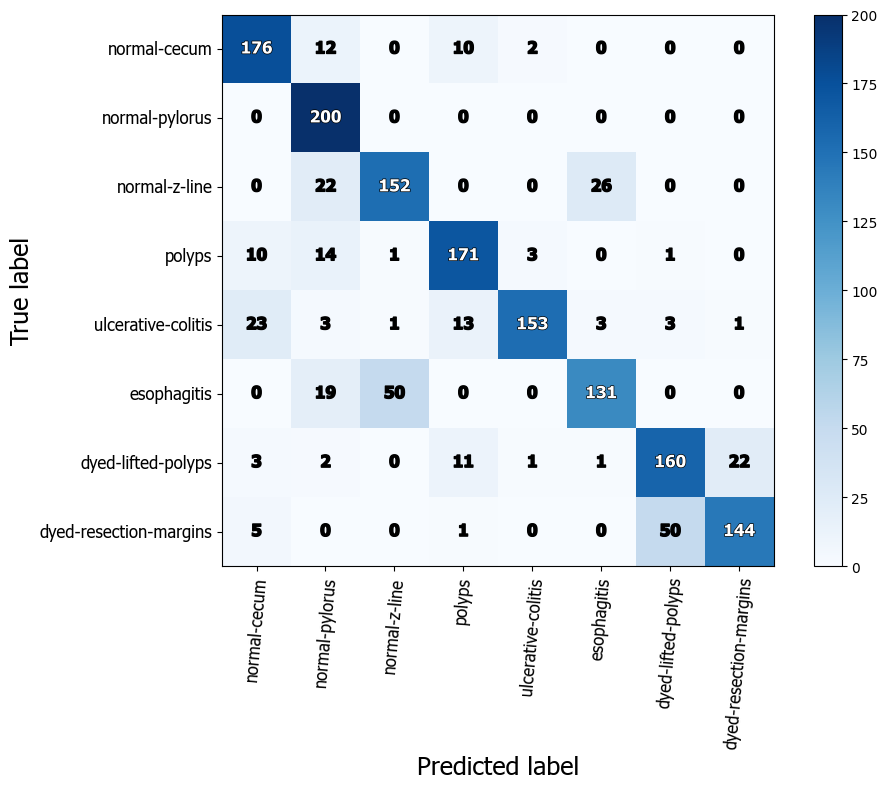

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.patheffects as path_effects
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
fontsize = 12

def confusion_matrix_test(cm, classes,
                          normalize=False,  # If true, all values in confusion matrix are between 0 and 1
                          title='',
                            cmap=plt.cm.Blues):  # Changed colormap to 'coolwarm'

    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85, fontfamily='Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily='Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        text = plt.text(j, i, cm[i, j],
                        fontfamily='Tahoma', 
                        fontsize=12, weight='bold',
                        horizontalalignment="center", verticalalignment='center',
                        color=color)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
                               path_effects.Normal()])

    plt.tight_layout()
    plt.ylabel('True label', fontfamily='Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily='Tahoma', fontsize=18)

# Print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps','ulcerative-colitis', 'esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins']

print(classification_report(test_labels, test_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(test_labels, test_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(5.25, 5.25), dpi=600)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()


plt.show()
